###Import the necessary libraries

We will use keras for this purpose. Please load the following packages before you proceed further.

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt

from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [15]:
main_dataset = pd.read_csv("CIPLA.csv") #Read the data

In [16]:
main_dataset

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,CIPLA,EQ,1349.40,1410.00,1457.35,1380.05,1457.35,1457.35,1441.36,21060,3.035496e+12,NaN,NaN,NaN
1,2000-01-04,CIPLA,EQ,1457.35,1537.00,1537.00,1430.00,1466.05,1465.25,1460.43,30215,4.412698e+12,NaN,NaN,NaN
2,2000-01-05,CIPLA,EQ,1465.25,1474.00,1474.00,1365.00,1441.00,1435.05,1428.11,33799,4.826872e+12,NaN,NaN,NaN
3,2000-01-06,CIPLA,EQ,1435.05,1434.00,1435.00,1349.00,1365.00,1355.85,1390.55,33083,4.600356e+12,NaN,NaN,NaN
4,2000-01-07,CIPLA,EQ,1355.85,1370.00,1389.90,1247.40,1247.40,1247.55,1267.49,66536,8.433351e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,CIPLA,EQ,935.60,935.60,940.00,902.15,907.95,905.40,914.11,10255697,9.374885e+14,161321.0,3451318.0,0.3365
5302,2021-04-27,CIPLA,EQ,905.40,913.00,919.50,901.00,911.20,912.40,909.22,5669049,5.154420e+14,120188.0,1126288.0,0.1987
5303,2021-04-28,CIPLA,EQ,912.40,914.35,918.00,902.95,906.25,910.20,909.94,7251009,6.597970e+14,134413.0,1772739.0,0.2445
5304,2021-04-29,CIPLA,EQ,910.20,911.95,917.40,904.00,906.00,906.50,910.22,4953091,4.508421e+14,88604.0,1122534.0,0.2266


###Trend

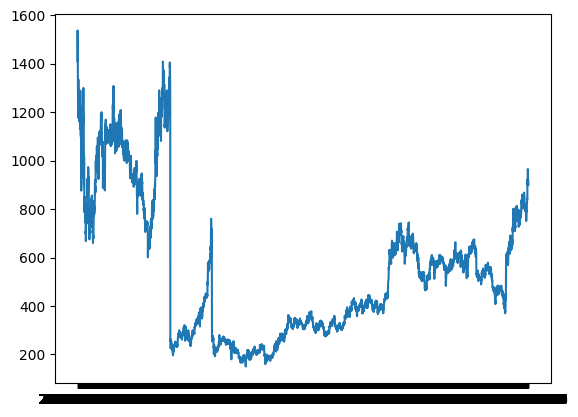

In [17]:
plt.plot(main_dataset.Date,main_dataset.Open)
plt.show()

In [18]:
dataset = main_dataset #Create another dataset same as the main dataset. Just to avoid replacing the main one.
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['Open'] #We will be left with only one column Cases for our dataset

In [19]:
dataset=dataset.to_frame() #Convert the Series into a dataframe object
dataset['Open_MA2']=dataset.expanding(min_periods=3).mean()  #min_periods is used to set the no. of periods for calculating MA. Mean is for calculating average.

In [20]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean() #ewm is used exponential moving average

In [21]:
dataset = dataset[dataset['Open_MA2'].notna()] #Remove the rows that have NAs

Let's look at the dataset

In [22]:
dataset.head()

,Open,Open_MA2,EMA
Date,,,
2000-01-05,1474.0,1473.666667,1473.750000
2000-01-06,1434.0,1463.750000,1453.875000
2000-01-07,1370.0,1445.000000,1411.937500
2000-01-10,1288.0,1418.833333,1349.968750
2000-01-11,1225.0,1391.142857,1287.484375


Here we will be predicting the column 'Cases'. Hence the target variable will be 'Cases'

In [23]:
#Cases is the column we have to predict.
target=dataset[['Open']]
del dataset['Open']

Adjust the shapes of predictor and target sets. For this, we remove the last row of both the datasets.

In [24]:
dataset.drop(dataset.index[len(dataset)-1], axis=0, inplace=True) #Drop the last row in dataset
target.drop(target.index[len(target)-1], axis=0, inplace=True) #Drop the last row in target

<ipython-input-24-4434fdf946d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.drop(target.index[len(target)-1], axis=0, inplace=True) #Drop the last row in target


In [25]:
x, y = dataset.values, target.values

We now scale the values for the model.

In [26]:
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library
y_scaled_set = MinMaxScaler()

X = x_scaled_set.fit_transform(x) #Fit to data and transform the data array x
Y = y_scaled_set.fit_transform(y.reshape(-1,1)) #Fit to data and transform the data array y. Reshape the y variable to long format

Split the X into train and test datasets.

Consider Training data as first 77 rows of the data and next 8 rows will be used for testing the model.

In [27]:
X_train_data=X[0:77,]
y_train_data=Y[0:77,]
X_test_data=X[78:86,]
y_test_data=Y[78:86,]

In [28]:
X_train_data = X_train_data.reshape((-1,1,2)) #Reshape train dataset to required format
X_test_data = X_test_data.reshape((-1,1,2)) #Reshape test dataset to required format

In [29]:
GRU_model = Sequential() #Use Sequential function from keras.model library
GRU_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data.
GRU_model.add(Dropout(0.2)) #Add a dropout layer to avoid overfitting.
GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units.
GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting.
GRU_model.add(Dense(1, activation='sigmoid')) #Finally, add a dense layer for getting a fully connected layer.
GRU_model.compile(loss='mse', optimizer='adam') #mse is mean square error which is the loss function and Adam optimizer will be the ooptimizer.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
GRU_model.fit(X_train_data,y_train_data,batch_size=250, epochs=500, validation_split=0.15, verbose=1)
#GRU_model.save("covid_GRU.h5") #Save the model if you want for reuse.

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0789 - val_loss: 0.0541
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0639 - val_loss: 0.0426
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0501 - val_loss: 0.0322
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0378 - val_loss: 0.0233
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0270 - val_loss: 0.0160
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0180 - val_loss: 0.0107
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0117 - val_loss: 0.0077
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0057 - val_loss: 0.0078
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0059 - val_loss: 0.0099
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0074 - val_loss: 0.0123
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0095

In [31]:
score = GRU_model.evaluate(X_test_data, y_test_data) #Evaluate model can be used to get the loss metric.
print('Score: {}'.format(score))
y_pred = GRU_model.predict(X_test_data) #Apply the built model on test data.
y_test_pred = y_scaled_set.inverse_transform(y_pred) #Use inverse transform to undo the scaling that was done before. This gives us the original values.
y_test_actual = y_scaled_set.inverse_transform(y_test_data) # Apply the inverse transform on the actual dataset for easy comparison of predicted vs actual.
#plt.plot(y_test_pred[-100:], label='Predicted') #Plot the predicted vs actual graph
#plt.plot(y_test_actual[-100:], label='Actual')
#plt.legend()
#plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0017
Score: 0.0016525639221072197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


In [32]:
test_Dates=main_dataset.Date[80:88] #create an object which has the dates for the Test data.

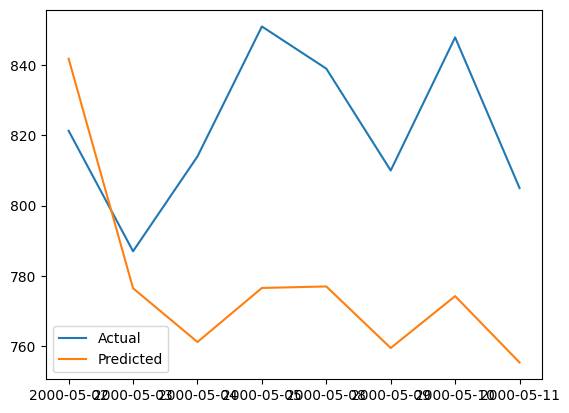

In [33]:
plt.plot(test_Dates,y_test_actual[-100:], label='Actual')
plt.plot(test_Dates,y_test_pred[-100:],label='Predicted')
plt.legend()
plt.show()

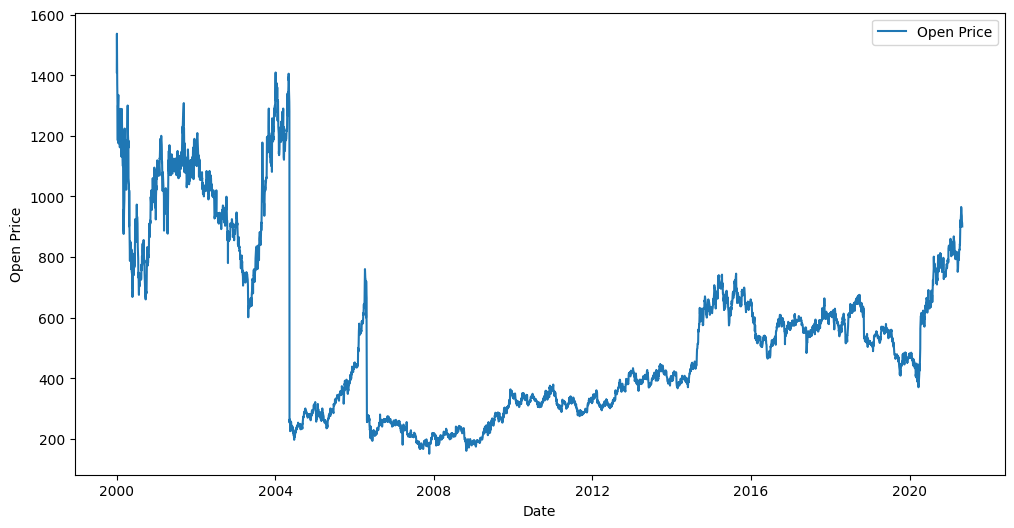

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.0569 - val_loss: 0.0077
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0319 - val_loss: 0.0037
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0117 - val_loss: 0.0049
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0044 - val_loss: 0.0097
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0042 - val_loss: 0.0108
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 8.5196e-04 - val_loss: 0.0017
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 6.0152e-04 - val_loss: 0.0016
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 5.2517e-04 - val_loss: 8.0787e-04
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - lo

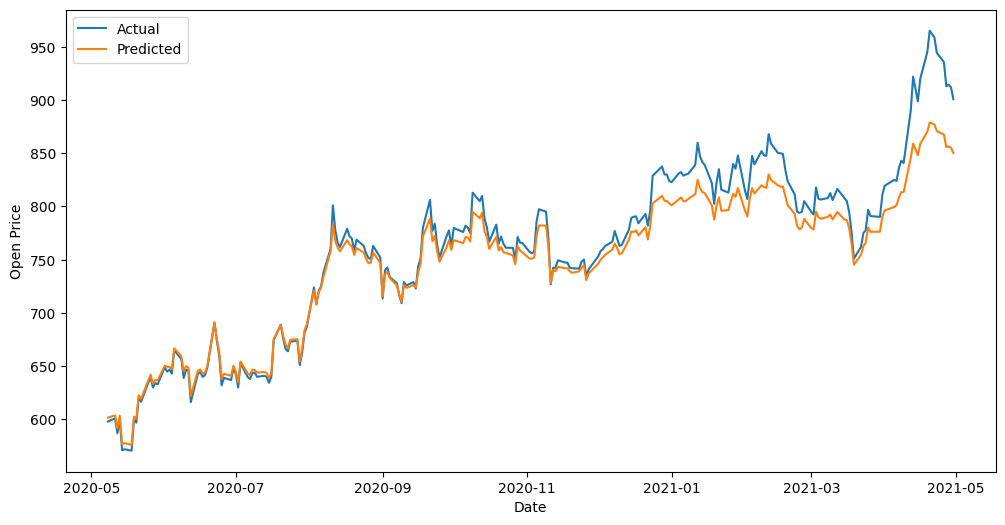

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset

dataset2 = pd.read_csv('/content/CIPLA.csv')

# Convert Date column to datetime format
dataset2['Date'] = pd.to_datetime(dataset2['Date'])
dataset2.set_index('Date', inplace=True)

# Plot the trend of the 'Open' column
plt.figure(figsize=(12, 6))
plt.plot(dataset2.index, dataset2['Open'], label='Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

# Feature Engineering
dataset2['Open_MA2'] = dataset2['Open'].expanding(min_periods=3).mean()
dataset2['EMA'] = dataset2['Open'].ewm(span=3, adjust=False).mean()
dataset2.dropna(inplace=True)

# Selecting all numerical columns for training
features = dataset2[['Open', 'High', 'Low', 'Close', 'Volume', 'Open_MA2', 'EMA']]
target = dataset2[['Open']]

# Scaling the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(features)
Y = scaler_y.fit_transform(target)

# Splitting into train and test sets
train_size = int(len(X) * 0.9)  # 90% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Reshaping for GRU input
X_train = X_train.reshape((-1, 1, X_train.shape[1]))
X_test = X_test.reshape((-1, 1, X_test.shape[1]))

# Building the GRU Model
model2 = Sequential()
model2.add(GRU(units=512, return_sequences=True, input_shape=(1, X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(GRU(units=256))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='mse', optimizer='adam')

# Training the model
model2.fit(X_train, y_train, batch_size=250, epochs=500, validation_split=0.15, verbose=1)

# Evaluating the model
score = model2.evaluate(X_test, y_test)
print(f'Score: {score}')

# Predicting
y_pred = model2.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plotting the results
test_Dates = dataset2.index[train_size:]
plt.figure(figsize=(12, 6))
plt.plot(test_Dates, y_test_actual, label='Actual')
plt.plot(test_Dates, y_test_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()
